<a href="https://colab.research.google.com/github/animesh-77/Active-Fire-Detection/blob/3algo/Generate_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.getcwd()

'/content'

In [11]:
!git clone --branch 3algo https://github.com/animesh-77/Active-Fire-Detection.git

Cloning into 'Active-Fire-Detection'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 92 (delta 42), reused 71 (delta 34), pack-reused 0
Unpacking objects: 100% (92/92), done.


In [19]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 2.0 MB/s 


## Murphy masks

We note that without the BQA file we cannot estimate the saturation of the band 6 or 5. Thus the $\beta$ value are affected. 

In [77]:
def normalise_RGB(img):
    img2= np.zeros(img.shape, dtype= float)
    for channel in range(3):
        img_band= img[:,:,channel]
        max_dn, min_dn= np.max(img_band), np.min(img_band)
        img_band = np.subtract(img_band, min_dn, casting= "unsafe")
        img_band = np.divide(img_band, (max_dn- min_dn), casting= "unsafe")
        img2[:,:,channel]= img_band
    return img2

In [93]:
# not using it right now

def get_saturation(BQA):
    """
    BQA a 2d numpy array with 16bit values
    
    returns
    a 2d array with all pixels with value 1 have at least 1 saturated bands
    """
    vals = [2724,2756,2804,2980,3012,3748,3780,6820,6852,6900,7076,7108,7844,7876,
            2728,2760,2808,2984,3016,3752,3784,6824,6856,6904,7080,7112,7848,7880,
            2732,2764,2812,2988,3020,3756,3788,6828,6860,6908,7084,7116,7852,7884]
    
    sat = np.zeros((BQA.shape), dtype=bool)

    for val in vals:
        sat = sat | (BQA==val)
        
    return sat.astype(int)

In [145]:
def getReflectance (band, add_band, mult_band, sun_elevation):
    '''A tiny function, used just to compute the Top of the Atmosphere reflectances, with correction
    for solar angle (given in degrees).
    band : all bands OR bands 1-7
    '''
    p = ((band * mult_band) + add_band) # TOA planetary reflectance, without correction for solar angle
    corrected = p / np.sin(np.radians (sun_elevation)) # TOA planetary reflectance, with correction for solar angle

    return p, corrected

In [167]:
#===============================================================================
# EQUATIONS (MURPHY)
#===============================================================================
# The following functions implement the equations in the Murphy's paper.

import cv2

def Meq2 (bands):
    '''Eq 2 (unambiguous fires).'''

    # Avoid divisions by 0!
    p5 = np.where (bands[5] == 0, np.finfo (float).eps, bands[5])
    p6 = np.where (bands[6] == 0, np.finfo (float).eps, bands[6])
    return (np.logical_and (bands[7] >= 0.15, np.logical_and (bands[7]/p6 >= 1.4, bands[7]/p5 >= 1.4)))

#-------------------------------------------------------------------------------

def Meq3 (bands, unamb, sat):
    '''Eq 3 (potential fires).'''

    neighborhood = cv2.dilate (unamb.astype (int), cv2.getStructuringElement (cv2.MORPH_RECT, (3,3))).astype (unamb.dtype)
    # Striclty speaking, we should take out from the neighborhood the pixels
    # that were set by eq 2, but the results will be joined anyway...
    #neighborhood = np.logical_xor (neighborhood, unamb)

    # Avoid divisions by 0!
    p5 = np.where (bands[5] > 0, np.finfo (float).eps, bands[5])
    return (np.logical_and (neighborhood, np.logical_or (np.logical_and (bands[6]/p5 >= 2.0, bands[6]>=0.5), sat)))


In [242]:
def getFireMaskMurphy (bands, saturated):
    '''This is the central function. Receives the (corrected) reflectance bands
and a binary mask indicating saturated pixels, and returns a binary fire mask.
    bands : all 10 bands. OR bands 1-7
    '''

    unamb_fires = Meq2 (bands)
    if np.any (unamb_fires): # Run eq 3 only if needed.
        # potential_fires = Meq3 (bands, unamb_fires, saturated)
        potential_fires = False
        final_mask = (unamb_fires | potential_fires)
        pass
    else:
        final_mask = unamb_fires

    return (final_mask.astype (int))

In [124]:
lines_to_see= [f"REFLECTANCE_MULT_BAND_{i}" for i in [5,6,7]]
lines_to_see.extend([f"REFLECTANCE_ADD_BAND_{i}" for i in [5,6,7]])
lines_to_see.append("SUN_ELEVATION")

with open("/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Metadata/LC08_L1TP_067091_20200810_20200810_01_RT_MTL.txt") as f:
    for line in f.readlines():
        if any(item in line for item in lines_to_see):
            print(line)

    SUN_ELEVATION = 21.64943273

    REFLECTANCE_MULT_BAND_5 = 2.0000E-05

    REFLECTANCE_MULT_BAND_6 = 2.0000E-05

    REFLECTANCE_MULT_BAND_7 = 2.0000E-05

    REFLECTANCE_ADD_BAND_5 = -0.100000

    REFLECTANCE_ADD_BAND_6 = -0.100000

    REFLECTANCE_ADD_BAND_7 = -0.100000



In [18]:
m5, m6, m7= 2.0000E-05, 2.0000E-05, 2.0000E-05
a5, a6, a7= -0.100000, -0.100000, -0.100000
sun_el = 21.64943273  

In [39]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

In [239]:
scenes_path= [os.path.join("/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Scenes", i) for i in 
              os.listdir("/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Scenes") 
              if i.endswith(".tif")]
scenes_path.sort()

masks_path = [os.path.join("/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Masks", i) for i in 
              os.listdir("/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Masks") 
              if (i.endswith(".tif") and "Murphy" in i)]
masks_path.sort()

In [240]:
display(scenes_path)
display(masks_path)

['/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Scenes/LC08_L1TP_067091_20200810_20200810_01_RT_p00582.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Scenes/LC08_L1TP_067091_20200810_20200810_01_RT_p00583.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Scenes/LC08_L1TP_067091_20200810_20200810_01_RT_p00690.tif']

['/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Masks/LC08_L1TP_067091_20200810_20200810_01_RT_Murphy_p00582.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Masks/LC08_L1TP_067091_20200810_20200810_01_RT_Murphy_p00583.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Masks/LC08_L1TP_067091_20200810_20200810_01_RT_Murphy_p00690.tif']

Are masks same ? True


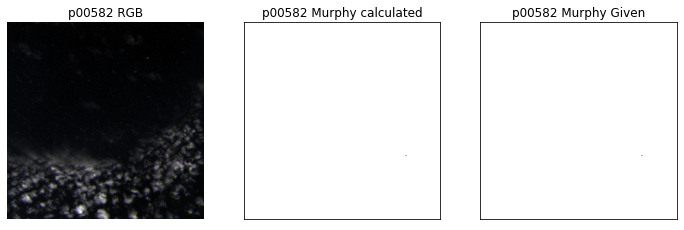

Are masks same ? True


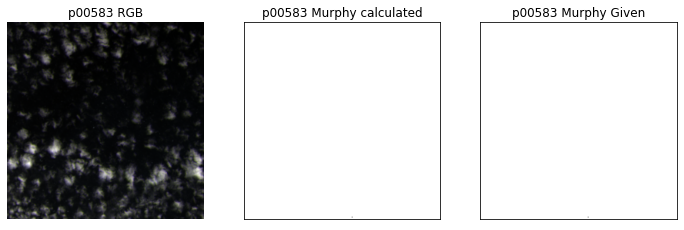

Are masks same ? False


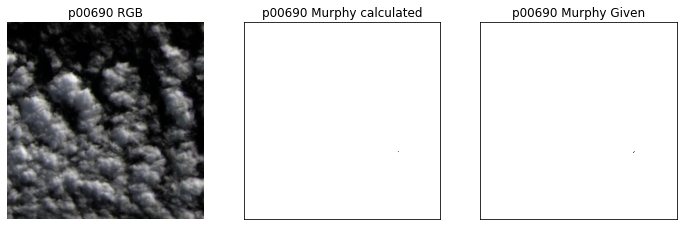

In [244]:
for index,paths in enumerate(zip(scenes_path, masks_path)):
    scene_path, mask_path= paths[0], paths[1]
    img= rasterio.open(scene_path)
    bands= img.read()
    img.close()

    b2= np.zeros((bands.shape[0]+1, bands.shape[1], bands.shape[2]), dtype= np.uint16)
    b2[1:]= bands
    bands= b2

    reflectance = np.zeros(bands.shape, dtype= float)
    corrected = np.zeros(bands.shape, dtype= float)
    
    # Get corrected reflectances for bands 1~7.
    for i in range (1,8):
        reflectance [i], corrected [i] = getReflectance(bands [i], a5, m5, sun_el)

    rgb= np.dstack((corrected[4], corrected[3], corrected[2]))
    rgb= normalise_RGB(rgb)

    sat= np.zeros(r.shape, dtype= int)
    murphy_mask= getFireMaskMurphy(corrected, sat)

    img= rasterio.open(mask_path)
    actual_mask= img.read()
    actual_mask= np.squeeze(actual_mask)
    img.close()

    print("Are masks same ?", np.all(actual_mask== murphy_mask))
    fig, ax = plt.subplots(1, 3, figsize=(12,40))
    scene_index= scene_path.split("/")[-1].split("_")[-1:]
    scene_index= "_".join(scene_index)[:-4]
    ax[0].imshow(rgb)
    ax[0].axis("off")
    ax[0].set_title(scene_index+" RGB")

    ax[1].set_title(scene_index+" Murphy calculated")
    ax[1].imshow(murphy_mask, cmap= "binary")
    ax[1].get_xaxis().set_ticks([])
    ax[1].get_yaxis().set_ticks([])

    ax[2].set_title(scene_index+" Murphy Given")
    ax[2].imshow(actual_mask, cmap= "binary")
    ax[2].get_xaxis().set_ticks([])
    ax[2].get_yaxis().set_ticks([])

    plt.show()

    